<a href="https://colab.research.google.com/github/jjh121386/plant-disease-swin/blob/main/plantdiseasepredictorswin92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch import nn, optim
from transformers import SwinForImageClassification, SwinConfig
import json
import zipfile
import os

In [ ]:
from google.colab import files
kaggle_json = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
kaggle_creds = next(iter(kaggle_json))
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(kaggle_json[kaggle_creds].decode('utf-8'))


In [ ]:
os.chmod('/root/.kaggle/kaggle.json', 0o600)


In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [02:04<00:00, 25.1MB/s]
100% 2.70G/2.70G [02:04<00:00, 23.2MB/s]


In [ ]:
with zipfile.ZipFile('new-plant-diseases-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('plantdisease')

In [ ]:
!ls plantdisease

'new plant diseases dataset(augmented)'  'New Plant Diseases Dataset(Augmented)'   test


In [ ]:
# Define the dataset directory
data_dir = 'plantdisease/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'


In [ ]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
# Prepare dataset
batch_size = 32
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

# Define the model
num_classes = len(class_names)  # Adjust based on your dataset
config = SwinConfig(image_size=224, num_labels=num_classes)
model = SwinForImageClassification(config)

# Add dropout to prevent overfitting
class SwinWithDropout(nn.Module):
    def __init__(self, model, dropout_rate=0.5):
        super(SwinWithDropout, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

model = SwinWithDropout(model)


In [ ]:
from google.colab import files

In [ ]:
uploaded_file = files.upload()
model_path = next(iter(uploaded_file))

Saving swin_transformer_plant_village.pth to swin_transformer_plant_village.pth


In [ ]:
# Define the SwinWithDropout model
class SwinWithDropout(nn.Module):
    def __init__(self, model, dropout_rate=0.5):
        super(SwinWithDropout, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        outputs = self.model(x)
        logits = outputs.logits
        logits = self.dropout(logits)
        return outputs

In [ ]:
# Initialize the base model and wrap it with SwinWithDropout
num_classes = len(class_names)
config = SwinConfig(image_size=224, num_labels=num_classes)
base_model = SwinForImageClassification(config)
model = SwinWithDropout(base_model)


In [ ]:
# Load the pre-trained weights
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)

<ipython-input-41-b252addd8480>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cpu'))


_IncompatibleKeys(missing_keys=['model.swin.embeddings.patch_embeddings.projection.weight', 'model.swin.embeddings.patch_embeddings.projection.bias', 'model.swin.embeddings.norm.weight', 'model.swin.embeddings.norm.bias', 'model.swin.encoder.layers.0.blocks.0.layernorm_before.weight', 'model.swin.encoder.layers.0.blocks.0.layernorm_before.bias', 'model.swin.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table', 'model.swin.encoder.layers.0.blocks.0.attention.self.relative_position_index', 'model.swin.encoder.layers.0.blocks.0.attention.self.query.weight', 'model.swin.encoder.layers.0.blocks.0.attention.self.query.bias', 'model.swin.encoder.layers.0.blocks.0.attention.self.key.weight', 'model.swin.encoder.layers.0.blocks.0.attention.self.key.bias', 'model.swin.encoder.layers.0.blocks.0.attention.self.value.weight', 'model.swin.encoder.layers.0.blocks.0.attention.self.value.bias', 'model.swin.encoder.layers.0.blocks.0.attention.output.dense.weight', 'model.swin.encoder.l

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Streaming output truncated to the last 5000 lines.
Validation Batch 499/550 Accuracy: 0.96875
Validation Batch 500/550 Accuracy: 0.84375
Validation Batch 501/550 Accuracy: 0.9375
Validation Batch 502/550 Accuracy: 0.9375
Validation Batch 503/550 Accuracy: 0.96875
Validation Batch 504/550 Accuracy: 0.84375
Validation Batch 505/550 Accuracy: 0.90625
Validation Batch 506/550 Accuracy: 0.96875
Validation Batch 507/550 Accuracy: 0.9375
Validation Batch 508/550 Accuracy: 0.9375
Validation Batch 509/550 Accuracy: 1.0
Validation Batch 510/550 Accuracy: 0.90625
Validation Batch 511/550 Accuracy: 0.90625
Validation Batch 512/550 Accuracy: 0.9375
Validation Batch 513/550 Accuracy: 0.90625
Validation Batch 514/550 Accuracy: 0.90625
Validation Batch 515/550 Accuracy: 0.90625
Validation Batch 516/550 Accuracy: 0.9375
Validation Batch 517/550 Accuracy: 0.96875
Validation Batch 518/550 Accuracy: 0.84375
Validation Batch 519/550 Accuracy: 0.96875
Validation Batch 520/550 Accuracy: 0.9375
Validation Bat

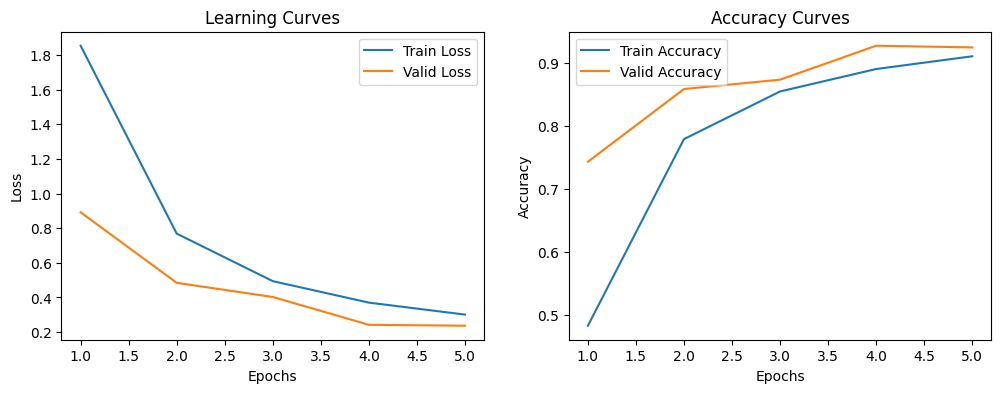

Accuracy: 0.9251
Precision: 0.9310
Recall: 0.9251
F1-score: 0.9247
Confusion Matrix:
[[466  20   0 ...   0   1   0]
 [  0 484   0 ...   0   0   0]
 [  0   0 419 ...   0   3   0]
 ...
 [  0   0   0 ... 483   0   0]
 [  0   0   0 ...   0 447   0]
 [  0   0   0 ...   0   0 476]]


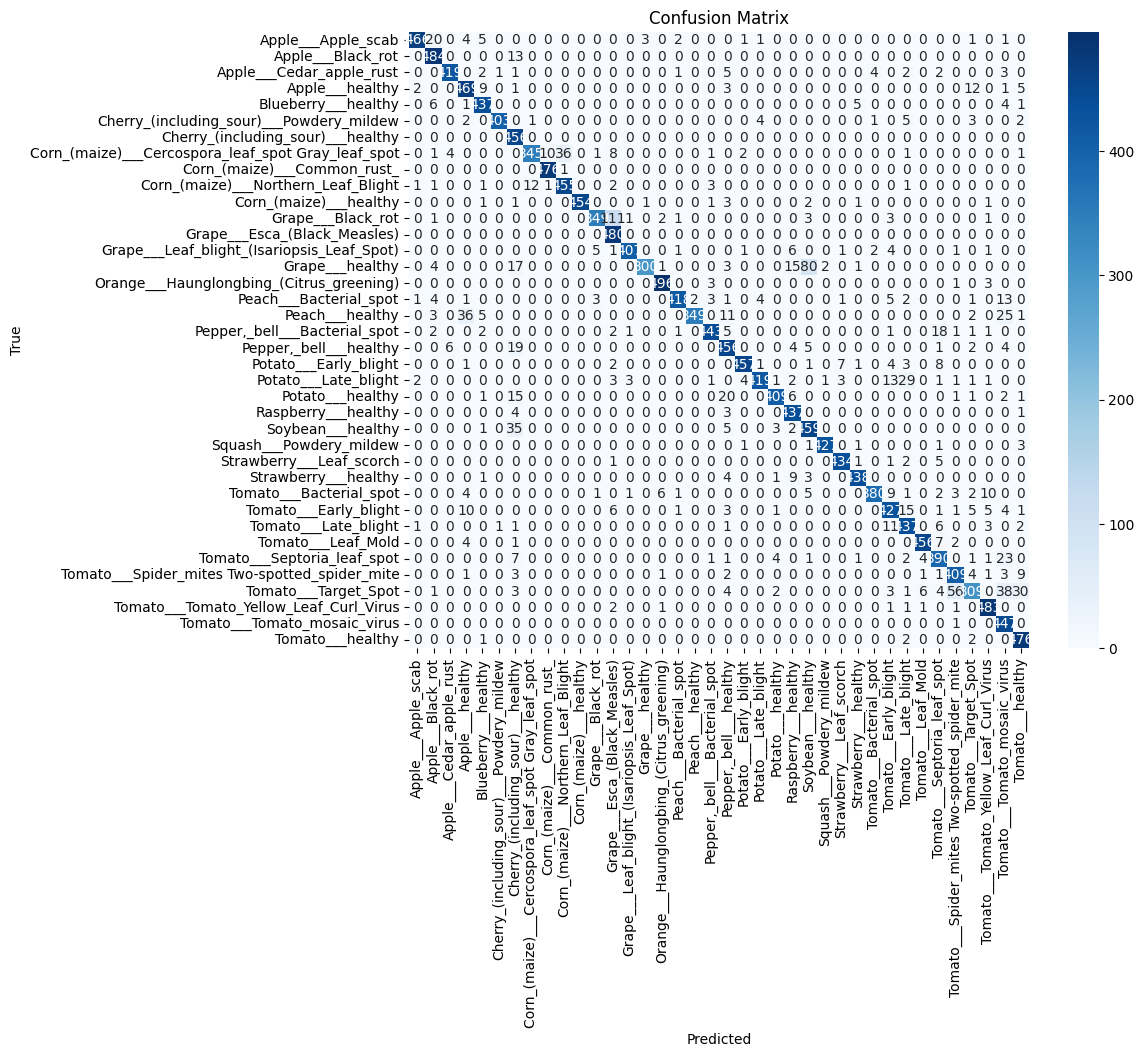

TypeError: 'NoneType' object is not subscriptable

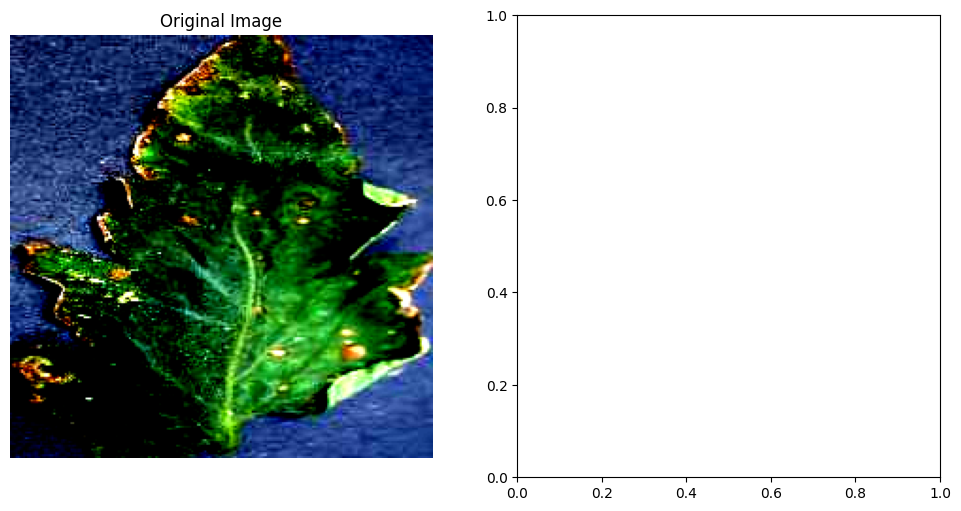

In [ ]:
# Training and validation loop with additional debug prints and learning curves
num_epochs = 5
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    for batch_idx, (images, labels) in enumerate(dataloaders['train']):
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloaders['train'])}")
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(logits, 1)
        correct_preds += torch.sum(preds == labels.data)
        print(f"Batch {batch_idx+1} Loss: {loss.item()}")

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = correct_preds.double() / dataset_sizes['train']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    print(f"Epoch {epoch+1} Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

    model.eval()
    running_loss = 0.0
    correct_preds = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloaders['valid']):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits
            loss = criterion(logits, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(logits, 1)
            correct_preds += torch.sum(preds == labels.data)
            print(f"Validation Batch {batch_idx+1}/{len(dataloaders['valid'])} Accuracy: {torch.sum(preds == labels.data).item() / labels.size(0)}")

    epoch_loss = running_loss / dataset_sizes['valid']
    epoch_acc = correct_preds.double() / dataset_sizes['valid']
    valid_losses.append(epoch_loss)
    valid_accuracies.append(epoch_acc.item())
    print(f"Epoch {epoch+1} Valid Loss: {epoch_loss:.4f}, Valid Accuracy: {epoch_acc:.4f}")

print("Training complete")

# Save the fine-tuned model
torch.save(model.state_dict(), 'swin_transformer_plant_village_finetuned_with_dropout.pth')

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.show()

# Evaluation metrics
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in dataloaders['valid']:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        logits = outputs.logits
        _, preds = torch.max(logits, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Attention maps
def show_attention_map(model, device, dataloader, num_images=5):
    model.eval()
    images_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if images_shown < num_images:
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
            axs[0].axis('off')
            axs[0].set_title('Original Image')

            attention_map = outputs.attentions[-1][0].sum(dim=0).cpu().numpy()
            axs[1].imshow(attention_map, cmap='viridis')
            axs[1].axis('off')
            axs[1].set_title('Attention Map')

            plt.show()
            images_shown += 1
        else:
            break

show_attention_map(model, device, dataloaders['valid'])


<ipython-input-49-0f0f2fe2e31a>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cpu'))


Accuracy: 0.9251
Precision: 0.9310
Recall: 0.9251
F1-score: 0.9247
Confusion Matrix:
[[466  20   0 ...   0   1   0]
 [  0 484   0 ...   0   0   0]
 [  0   0 419 ...   0   3   0]
 ...
 [  0   0   0 ... 483   0   0]
 [  0   0   0 ...   0 447   0]
 [  0   0   0 ...   0   0 476]]


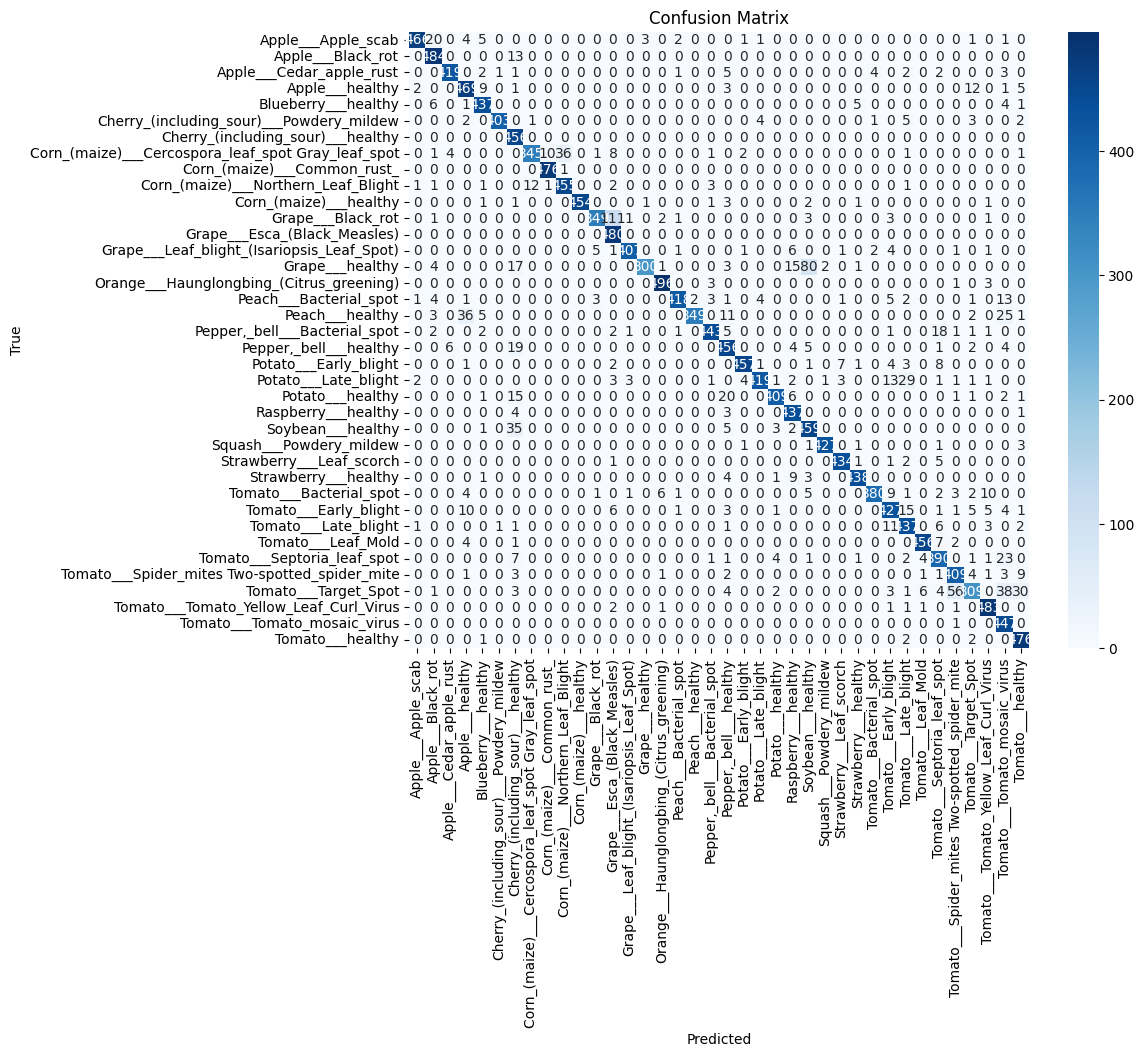

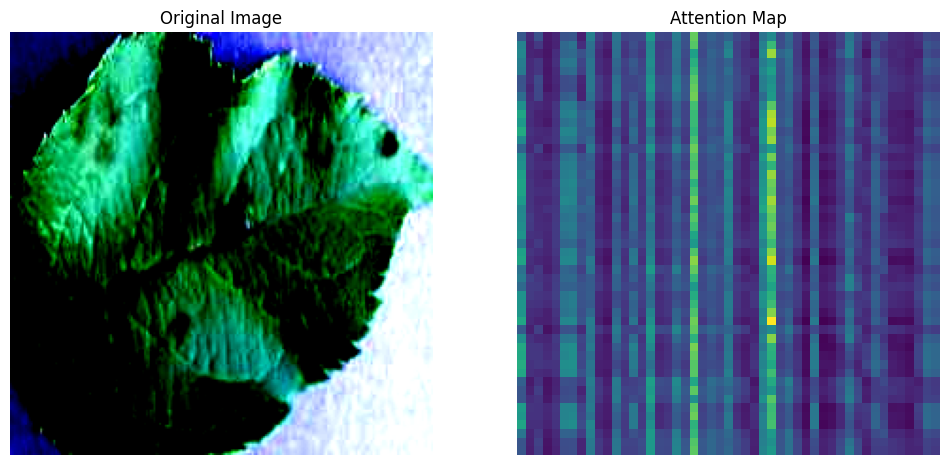

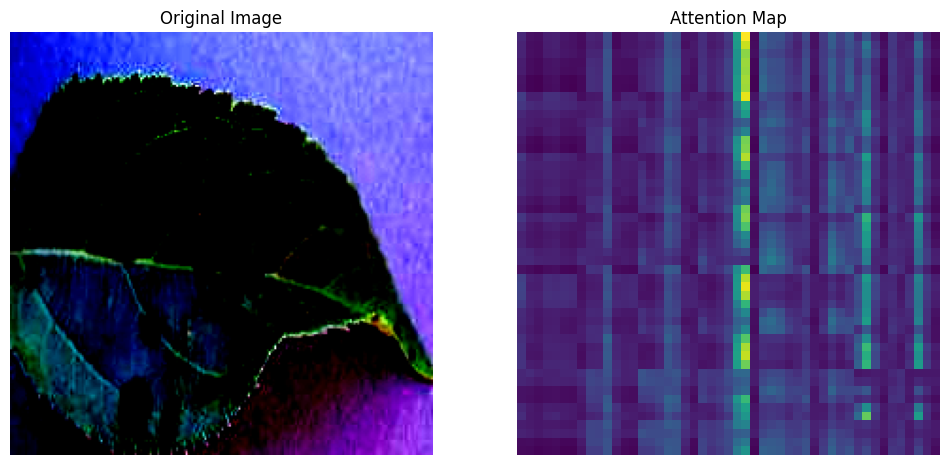

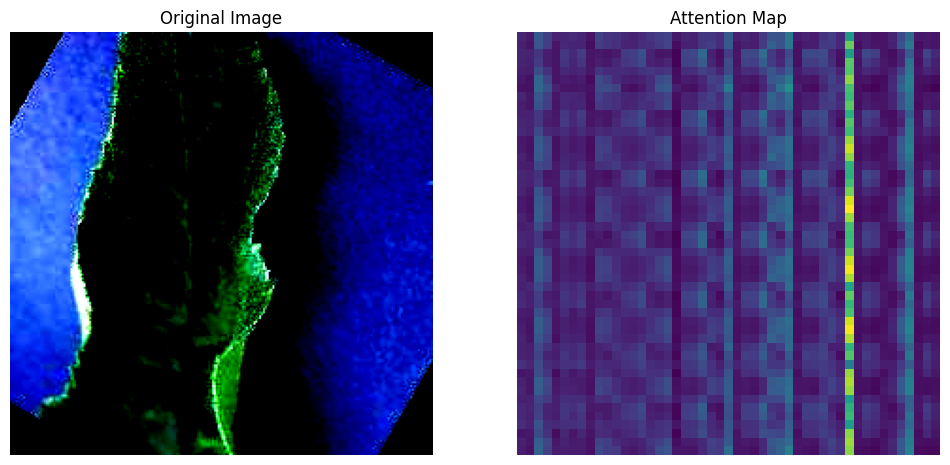

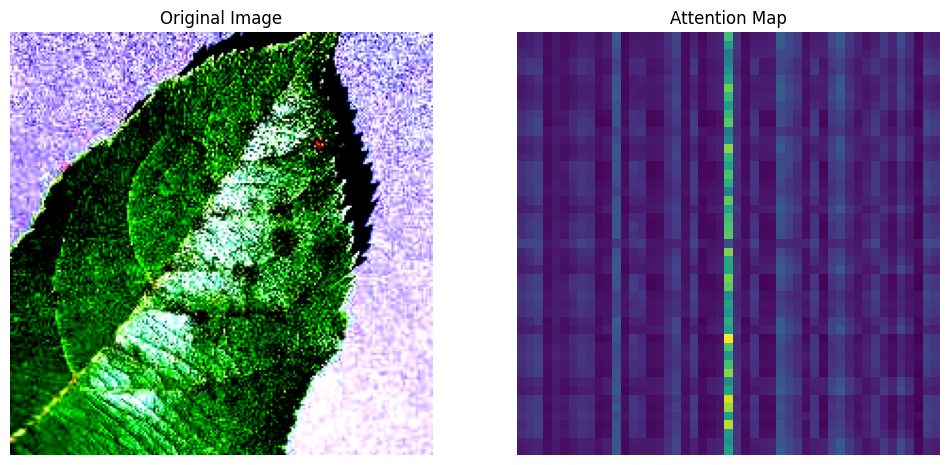

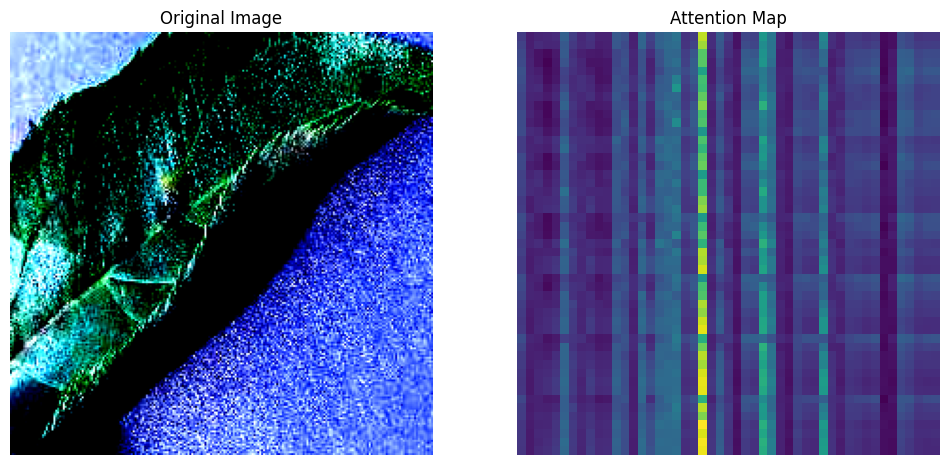

In [ ]:
import torch
from transformers import SwinForImageClassification, SwinConfig
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the dataset directory and data transforms
data_dir = 'plantdisease/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
data_transforms = {
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Prepare the validation dataset
batch_size = 32
image_datasets = {'valid': datasets.ImageFolder(os.path.join(data_dir, 'valid'), data_transforms['valid'])}
dataloaders = {'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False, num_workers=2)}
class_names = image_datasets['valid'].classes

# Define the SwinWithDropout model
class SwinWithDropout(nn.Module):
    def __init__(self, model, dropout_rate=0.5):
        super(SwinWithDropout, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        outputs = self.model(x)
        logits = outputs.logits
        logits = self.dropout(logits)
        return outputs

# Define the model configuration and initialize the base model
num_classes = len(class_names)  # Adjust based on your dataset
config = SwinConfig(image_size=224, num_labels=num_classes, output_attentions=True)
base_model = SwinForImageClassification(config)
model = SwinWithDropout(base_model)

# Load the saved model weights
model_path = 'swin_transformer_plant_village_finetuned_with_dropout.pth'
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()

# Evaluation setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluation metrics
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in dataloaders['valid']:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        logits = outputs.logits
        _, preds = torch.max(logits, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Attention maps
def show_and_save_attention_map(model, device, dataloader, save_path_prefix, num_images=5):
    model.eval()
    images_shown = 0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if images_shown < num_images:
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
            axs[0].axis('off')
            axs[0].set_title('Original Image')

            attention_map = outputs.attentions[-1][0].sum(dim=0).detach().cpu().numpy()
            attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())  # Normalize to [0, 1]
            axs[1].imshow(attention_map, cmap='viridis')
            axs[1].axis('off')
            axs[1].set_title('Attention Map')

            plt.savefig(f'{save_path_prefix}_attention_map_{i}.png')
            plt.show()
            images_shown += 1
        else:
            break

show_and_save_attention_map(model, device, dataloaders['valid'], 'attention_map')